In [76]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [77]:
sales_data = pd.read_csv("./data/sales.csv")
sales_data.head()

print(sales_data.state_holiday.unique())

le = LabelEncoder()
sales_data.state_holiday = le.fit_transform(sales_data.state_holiday)

['0' 'a' 'c' 'b']


In [78]:
sales_data.head()

print(sales_data.dtypes)

Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday           int64
school_holiday          int64
sales                   int64
dtype: object


## Handle date column

In [79]:
sales_data.date = pd.to_datetime(sales_data.date)
sales_data["month"] = sales_data.date.dt.month
sales_data["year"] = sales_data.date.dt.year

sales_data.drop(columns=["date"], inplace=True)

print(sales_data.head())

   Unnamed: 0  store_ID  day_of_week  nb_customers_on_day  open  promotion  \
0      425390       366            4                  517     1          0   
1      291687       394            6                  694     1          0   
2      411278       807            4                  970     1          1   
3      664714       802            2                  473     1          1   
4      540835       726            4                 1068     1          1   

   state_holiday  school_holiday  sales  month  year  
0              0               0   4422      4  2013  
1              0               0   8297      4  2015  
2              0               0   9729      8  2013  
3              0               0   6513      5  2013  
4              0               0  10882     10  2013  


## Set missing index name

In [80]:
sales_data.rename(columns={sales_data.columns[0]: 'index'}, inplace=True)

## Check missing values

In [81]:
print(sales_data.isnull().sum())

index                  0
store_ID               0
day_of_week            0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
month                  0
year                   0
dtype: int64


## Check corrolation between features

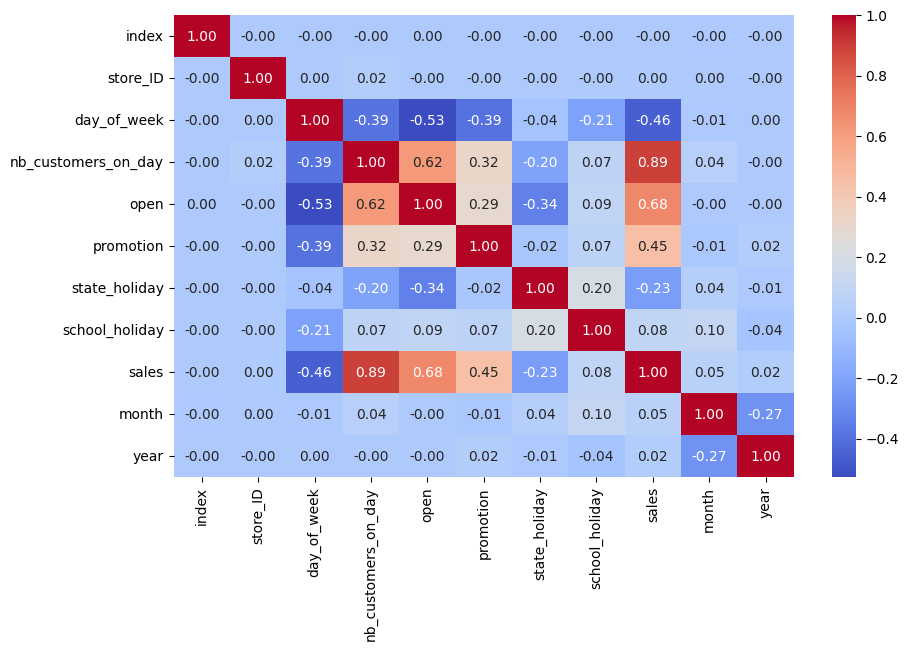

In [82]:
corrolation_matrix = sales_data.corr(numeric_only=True)

plt.figure(figsize=[10, 6])
sns.heatmap(corrolation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [83]:
scalar = StandardScaler()
X_scaled = scalar.fit_transform(sales_data)

sales_data_scaled = pd.DataFrame(X_scaled, columns=sales_data.columns)

## Select Features and label

In [84]:
y = sales_data_scaled.sales
X = sales_data_scaled.drop(columns=["sales"], axis=1)

## Test Linear regression without cross validation

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

lr_model = LinearRegression().fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

r2_score_train = r2_score(y_train, y_train_pred)
r2_score_test = r2_score(y_test, y_test_pred)

print(f"R2 Score (train): {r2_score_train}, R2 Score (test): {r2_score_test}")

R2 Score (train): 0.8541135123427566, R2 Score (test): 0.8541699899508618


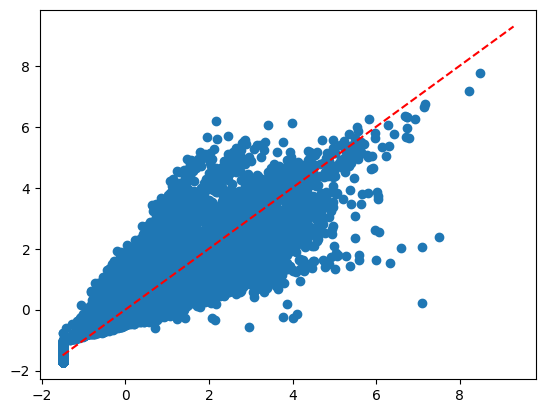

In [86]:
plt.scatter(y_test, y_test_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

## Random Forest Regression

In [87]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0, n_jobs=-1).fit(X_train, y_train)
y_test_pred_rf = rf_model.predict(X_test)

r2_score_test_rf = r2_score(y_test, y_test_pred_rf)

print(r2_score_test_rf)


0.9375413394364186


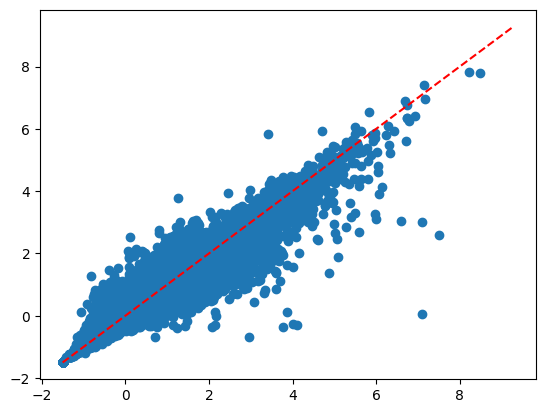

In [88]:
plt.scatter(y_test, y_test_pred_rf)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

## Find the best hyper parameter

In [94]:
rf_without_args = RandomForestRegressor()

param_dist = {
    "n_jobs": [-1],
    'n_estimators': [20, 50, 100],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rscv = RandomizedSearchCV(rf_without_args, param_distributions=param_dist, n_iter=50, random_state=1)
rscv.fit(X_train, y_train)

print("Best params", rscv.best_params_)

c:\Users\Alejandro Zahinos\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
85 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Alejandro Zahinos\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Alejandro Zahinos\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~

Best params {'n_jobs': -1, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


In [95]:
best_model = rscv.best_estimator_
y_best_model_pred = best_model.predict(X_test)

r2_best_model = r2_score(y_test, y_best_model_pred)

print(r2_best_model)

0.9067485226388914


## Boosting 

In [91]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_jobs': [-1],
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2.0]
}

xgb_random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

xgb_random_search.fit(X_train, y_train)

print("Best parameters", xgb_random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_jobs': -1, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}


In [93]:
xgb_best_model = xgb_random_search.best_estimator_

y_pred_xgb = xgb_best_model.predict(X_test)
r2_best_model_xgb = r2_score(y_test, y_pred_xgb)

print(r2_best_model_xgb)

0.9448510212003403


# Result

- first we checked the data and transformed it
- We used LabelEncoder for the Category state holiday
- we also split the date column into multiple colums representing year and month and droped date
- 